In [119]:
import pandas as pd
import numpy as np
import glob
import os
    
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from Bio import SeqIO

import xmltodict
from flatten_json import flatten
import json

In [15]:
from scipy.stats import spearmanr

In [3]:
rule_precedences = {
'BlastRuleIS':96,
'BlastRuleException':95,
'exception':77,
'equivalog':70,
'hypoth_equivalog':70,
'equivalog_domain':70,
'hypoth_equivalog_domain':70,
'BlastRuleEquivalog':69,
'BlastRuleSubPlus':65,
'Domain architecture':60,
'PfamEq':57,
'subfamily':55,
'subfamily_domain':52,
'BlastRuleSubMinus':50,
'BlastRuleCOLLAB':41,
'PfamAutoEq':37,
'paralog':36,
'paralog_domain':35,
'superfamily':33,
'domain':30,
'repeat':25,
'signature':22
}

In [4]:
"""
############### SPARCLE ###############
"""
# function to read xml
def read_sparcle_xml(file_path):
    with open(file_path, 'r') as xml_handle:
        xml_data = xml_handle.read()
    return read_xml_as_df(xml_data)    

# function to turn string of xml into a file path
def read_xml_as_df(xml_to_parse):
    #this will create a json object
    data = json.loads(json.dumps(xmltodict.parse(xml_to_parse)))

    # this will put all items into a single row
    dic_flattened = (flatten(d, '.') for d in data['NameAssignment']['Protein'])
    df = pd.DataFrame(dic_flattened)
    return df

# function to parse sparcle data 
def parse_sparcle_data(df):
    df['orf_uid'] = sparcle_data['@seq-id'].apply(lambda x: x.split('|')[1])
    df = df.rename(columns={'AssignedName':'name',
                       'Support.SPARCLE.SpecificArch':'assignment_acc',
                       'Precedence.confidence':'precedence'})
    df['precedence'] = df['precedence'].astype(int)
    columns = ['orf_uid', 'name', 'assignment_acc', 'precedence']
    return df[columns]

"""
############### HMM ###############
"""
hmm_table_columns = ['target_name','target_accession','query_name','query_accession', 
                      'full_e_value', 'full_score', 'full_bias', 
                      'best_domain_e_value', 'best_domain_score', 'best_domain_bias', 
                      'exp', 'reg', 'clu',  'ov', 'env', 'dom', 'rep', 'inc']

# function to read HMMER3.0 tblout as pandas df
def read_hmm_table_pandas(file_path):
    # read table with special parameters
    pfam_as_table = pd.read_table(file_path, skiprows=3,  skipfooter=10, sep='\s+', header=None, engine='python', usecols=list(range(18)))
    pfam_as_table.columns = hmm_table_columns
    return pfam_as_table

def parse_hmm_data(df, hmm_md, precedences):
    # merge with hmm data
    merged = pd.merge(df, hmm_md[['#ncbi_accession', 'product_name', 'sequence_cutoff', 'domain_cutoff', 'family_type']],
         left_on='query_accession', right_on='#ncbi_accession')
    # subset to hits
    merged = merged[(merged.full_score >= merged.sequence_cutoff) & (merged.best_domain_score >= merged.domain_cutoff)]
    # reformat columns
    merged['precedence'] = merged['family_type'].map(precedences).astype(int)
    merged = merged.rename(columns={'target_name':'orf_uid',
                                    'query_accession':'assignment_acc',
                                    'product_name':'name'})
    columns = ['orf_uid', 'name', 'assignment_acc', 'precedence']
    return merged[columns]

"""
############### BLAST ###############
"""

blast6_fmt_str = '"6 qseqid sseqid pident length mismatch gapopen qlen qstart qend slen sstart send evalue bitscore"'

def read_blast_table(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None)
    data.columns = blast6_fmt_str.replace('"', '').split(' ')[1:]
    
    return data

def parse_blast_data(df, blastrules_md, precedences):
    
    df['scov'] = (df['send'] - df['sstart']) / df['slen']
    df['qcov'] = (df['qend'] - df['qstart']) / df['qlen']
    
    # split acc column
    df['assignment_acc'] = df['sseqid'].apply(lambda x: x.split('|')[3].split('.')[0])

    blastrules_cols = ['Name', 'WP_Proteins', 'Identity', 'Model_pct', 'Target_pct', 'Rule_type']
    data_cols = ['qseqid', 'assignment_acc', 'pident', 'scov', 'qcov']
    
    # merge with metadata to get cutoffs and precedence
    merged = pd.merge(df[data_cols], blastrules_md[blastrules_cols], left_on='assignment_acc', right_on='WP_Proteins')

    # filter
    merged = merged[(merged['pident'] >= merged['Identity'])
                & (merged['scov'] >= merged['Model_pct'])
                & (merged['qcov'] >= merged['Target_pct'])]

    # add precedence
    merged['precedence'] = merged['Rule_type'].map(precedences).astype(int)
    columns = ['orf_uid', 'name', 'assignment_acc', 'precedence']
    
    # renaming
    merged = merged.rename(columns={'qseqid':'orf_uid',
                                'Name':'name'})
    return merged[columns]

### Test pipeline

In [5]:
eggo_data = pd.read_csv('/data/mhoffert/tools/eggo/Data/EGGO.csv')
blastrules = pd.read_csv('/data/mhoffert/db/pgap_ribosomal/blastrules_4.0/blast-rules_4.0.tsv', sep='\t', encoding='latin1')
pgap_hmm = pd.read_csv('/data/mhoffert/db/pgap_ribosomal/hmm_PGAP.tsv', sep='\t')
cddid_tbl = pd.read_csv('/data/mhoffert/db/cdd/cddid.tbl', sep='\t', header=None)
cddid_tbl.columns = '''PSSM-Id
CD accession
CD short name
CD description
PSSM-Length'''.split('\n')

Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.


In [138]:
eggo_data.tail(100)

,Unnamed: 0,nHE,FilteredSequences,d,LowerCI,UpperCI,d.madin,LowerCI.madin,UpperCI.madin,Assembly,Source,Mode,Type,Environment,genome
216974,1394106,57,345,0.922766,0.767856,1.114381,1.073322,0.924640,1.249920,GCA_003471045.1_ASM347104v1,Zou et al.,Full,Isolate,Human Gut,RS_GCA_003471045.1
216975,1395106,63,517,0.436928,0.320185,0.604822,0.588325,0.453697,0.770502,GCA_003439475.1_ASM343947v1,Zou et al.,Full,Isolate,Human Gut,RS_GCA_003439475.1
216976,1396106,58,136,1.466236,1.220827,1.769575,1.460707,1.242807,1.723307,GCA_003436485.1_ASM343648v1,Zou et al.,Full,Isolate,Human Gut,RS_GCA_003436485.1
216977,1397104,56,776,0.772032,0.639823,0.936348,0.869927,0.746103,1.017763,GCA_003463005.1_ASM346300v1,Zou et al.,Full,Isolate,Human Gut,RS_GCA_003463005.1
216978,1398106,53,112,0.669060,0.496676,0.913165,0.558392,0.428929,0.734397,GCA_003475665.1_ASM347566v1,Zou et al.,Full,Isolate,Human Gut,RS_GCA_003475665.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217069,1489106,56,147,0.907232,0.760162,1.087680,1.042848,0.900257,1.211801,GCA_003604095.1_ASM360409v1,Zou et al.,Full,Isolate,Human Gut,RS_GCA_003604095.1
217070,1490106,58,293,1.036478,0.876908,1.230055,1.109724,0.967582,1.276200,GCA_003481215.1_ASM348121v1,Zou et al.,Full,Isolate,Human Gut,RS_GCA_003481215.1
217071,1491106,56,379,1.137268,0.944631,1.376055,1.258940,1.083702,1.467270,GCA_003469435.1_ASM346943v1,Zou et al.,Full,Isolate,Human Gut,RS_GCA_003469435.1
217072,1492106,56,344,0.821306,0.684857,0.989670,0.919549,0.792849,1.069888,GCA_003635365.1_ASM363536v1,Zou et al.,Full,Isolate,Human Gut,RS_GCA_003635365.1


In [ ]:
# Get the names of all of the genomes which have EGGO data
test_genomes = []
for index, row in eggo_data.head(100000).iterrows():
    genome_id = 'RS_'+'_'.join(row['Assembly'].split('_')[:2])
    display(index, len(test_genomes))
    clear_output(wait=True)
    # print(genome_id)
    if os.path.exists(f'/data/mhoffert/genomes/GTDB_r207/protein_faa_reps/bacteria/{genome_id}_protein.faa'):
        test_genomes.append(f'{genome_id}')
    

50160

5473

In [141]:
with open('/data/mhoffert/realmichaelhoffert/ribosomal_proteins/test_genomes_list.txt', 'w') as handle:
    handle.write('\n'.join(test_genomes) + '\n')

### First: Sparcle pipeline
Run from installation directory for Sparcle pipeline

In [8]:
print(f'./rpsblast -parse_deflines -query {test_genome} -db /data/mhoffert/db/cdd/ribosomal_proteins -evalue 0.01 -outfmt 11 -out {out_path}.asn')
print(f'./sparclbl -p precedences_sample.txt -o {out_path}.xml {out_path}.asn')


/data/mhoffert/tools/SparcleLabel/SparcleLabel-x64-linux
running command 1
./rpsblast -parse_deflines -query /data/mhoffert/genomes/GTDB_r207/protein_faa_reps/bacteria/RS_GCF_009268075.1_protein.faa -db /data/mhoffert/db/cdd/ribosomal_proteins -evalue 0.01 -outfmt 11 -out /data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_009268075.1.asn
/data/mhoffert/tools/SparcleLabel/SparcleLabel-x64-linux
running command 2
./sparclbl -p precedences_sample.txt -o /data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_009268075.1.xml /data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_009268075.1.asn


Run: `./run_ribosomal_pipeline.sh /data/mhoffert/realmichaelhoffert/ribosomal_proteins/test_genomes_list.txt` from /data/mhoffert/realmichaelhoffert/ribosomal_proteins/  
For some reason, running the commands in the jupter notebook doesn't work

### Second: HMM pipeline

In [ ]:
%%time
faa_path = '/data/mhoffert/genomes/GTDB_r207/protein_faa_reps/bacteria/'
for i, test_genome in enumerate(test_genomes):
    display(f'{i / len(test_genomes) * 100:.3f}%')
    clear_output(wait=True)
    
    out_path = f'/data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/{test_genome}'
    os.system(f'hmmsearch --cpu 8 -o {out_path}.hmmout --tblout {out_path}.tblout /data/mhoffert/db/pgap_ribosomal/ribosomal_hmm {faa_path}{test_genome}_protein.faa')

'3.611%'

In [12]:
print(f'hmmsearch --cpu 8 -o {out_path}.hmmout --tblout {out_path}.tblout /data/mhoffert/db/pgap_ribosomal/ribosomal_hmm {faa_path}{test_genome}_protein.faa')

hmmsearch --cpu 8 -o /data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_009759685.1.hmmout --tblout /data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_009759685.1.tblout /data/mhoffert/db/pgap_ribosomal/ribosomal_hmm /data/mhoffert/genomes/GTDB_r207/protein_faa_reps/bacteria/RS_GCF_009759685.1_protein.faa


In [153]:
linspace = [int(i) for i in np.linspace(0, len(test_genomes), 13)]
for i in range(len(linspace)-1):
    print(linspace[i], linspace[i+1])
    list_chunk = test_genomes[linspace[i]:linspace[i+1]]
    
    with open(f'/data/mhoffert/realmichaelhoffert/ribosomal_proteins/test_genomes_list_chunk{i}.txt', 'w') as out_handle:
        out_handle.write('\n'.join(list_chunk))

0 817
817 1634
1634 2451
2451 3268
3268 4085
4085 4902
4902 5719
5719 6536
6536 7353
7353 8170
8170 8987
8987 9804


In [148]:
np.linspace(0, len(test_genomes), 13)

array([   0.,  817., 1634., 2451., 3268., 4085., 4902., 5719., 6536.,
       7353., 8170., 8987., 9804.])

### Third: blast pipeline

In [55]:
%%time
blast_db = '/data/mhoffert/db/pgap_ribosomal/blastrules_4.0/ribosomal_proteins'
blast6_fmt_str = '"6 qseqid sseqid pident length mismatch gapopen qlen qstart qend slen sstart send evalue bitscore"'
for i, test_genome in enumerate(test_genomes):
    display(f'{i / len(test_genomes) * 100:.2f}%')
    clear_output(wait=True)
    
    out_path = f'/data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/{test_genome}'
    os.system(f'blastp -num_threads 16 -query {faa_path}{test_genome}_protein.faa -db {blast_db} -out {out_path}.blast6out -outfmt {blast6_fmt_str}')

CPU times: user 633 ms, sys: 107 ms, total: 740 ms
Wall time: 47min 20s


## Parsing results

In [122]:
low_accuracy_annotations = ['60S ribosomal protein L13', '60S ribosomal protein L34',
       'Ribosomal_L2_C domain-containing protein',
       'bL20 family ribosomal protein', 'bL33 family ribosomal protein',
       'eS10 family ribosomal protein',
       'mitochondrial small ribosomal subunit protein uS9m',
       'mitochondrion-specific ribosomal mL54 family protein',
       'ribosomal protein S17', 'ribosomal protein S7',
       'sigma 54 modulation/S30EA ribosomal C-terminal domain-containing protein',
       'uL13 family ribosomal protein']

In [123]:
all_selected_ribosomal_annotations = []
for i, test_genome in enumerate(test_genomes):
    display(f'{i / len(test_genomes) * 100:.2f}%')
    clear_output(wait=True)
    
    out_path = f'/data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/{test_genome}'
    
    # parse the sparcle data
    sparcle_data = read_sparcle_xml(f'{out_path}.xml')
    sparcle_df = parse_sparcle_data(sparcle_data)

    # parse the blast data
    blast_data = read_blast_table(f'{out_path}.blast6out')
    blast_df = parse_blast_data(blast_data, blastrules, rule_precedences)

    # parse the hmm data
    hmm_data = read_hmm_table_pandas(f'{out_path}.tblout')
    hmm_df = parse_hmm_data(hmm_data, pgap_hmm, rule_precedences)

    # for df in [sparcle_df, blast_df, hmm_df]:
    #     print(df.shape)
    # time.sleep(1)

    all_ribosomal_proteins = pd.concat([sparcle_df, blast_df, hmm_df])

    selected_ribosomal_annotations = all_ribosomal_proteins.groupby('orf_uid').apply(lambda x: x.sort_values('precedence', ascending=False).iloc[0, :])
    selected_ribosomal_annotations = selected_ribosomal_annotations[selected_ribosomal_annotations.precedence > 5]
    all_selected_ribosomal_annotations.append(selected_ribosomal_annotations.assign(genome=test_genome))
    # test_genome_split

    nt_fasta_base_path = '/data/mhoffert/genomes/GTDB_r207/protein_fna_reps/bacteria/'
    nt_fasta = f'{nt_fasta_base_path}{test_genome}_protein.fna'

    # import time

    with open(nt_fasta, 'r') as input_fasta:
        records = [r for r in SeqIO.parse(input_fasta, 'fasta')]

    for r in records:
        if r.id in selected_ribosomal_annotations.head(50).index:
            annotation = selected_ribosomal_annotations.loc[r.id]
            r.id = f'{r.id} {annotation["name"]} ({annotation["assignment_acc"]})'
            r.description = ' '.join(r.description.split(' ')[1:])

    with open(f'/data/mhoffert/genomes/GTDB_r207/grodon_format/{test_genome}_grodon_format.fna', 'w') as out_handle:
            SeqIO.write(records, out_handle, 'fasta')

FileNotFoundError: [Errno 2] No such file or directory: '/data/mhoffert/genomes/GTDB_r207/pgap_ribosomal_results/RS_GCF_009759685.1.xml'

In [136]:
selected_ribosomal_annotations[selected_ribosomal_annotations.name.str.contains('ribosomal protein')]

,orf_uid,name,assignment_acc,precedence
orf_uid,,,,
NZ_FZLN01000001.1_1069,NZ_FZLN01000001.1_1069,50S ribosomal protein L25,NF004612.1,70
NZ_FZLN01000001.1_1080,NZ_FZLN01000001.1_1080,50S ribosomal protein L32,TIGR01031.1,70
NZ_FZLN01000001.1_1133,NZ_FZLN01000001.1_1133,50S ribosomal protein L20,NF003526.0,70
NZ_FZLN01000001.1_1134,NZ_FZLN01000001.1_1134,50S ribosomal protein L35,TIGR00001.1,70
NZ_FZLN01000001.1_119,NZ_FZLN01000001.1_119,50S ribosomal protein L21,TIGR00061.1,70
NZ_FZLN01000001.1_120,NZ_FZLN01000001.1_120,50S ribosomal protein L27,TIGR00062.1,70
NZ_FZLN01000001.1_436,NZ_FZLN01000001.1_436,30S ribosomal protein S20,TIGR00029.2,70
NZ_FZLN01000001.1_503,NZ_FZLN01000001.1_503,30S ribosomal protein S1,NF005208.0,70
NZ_FZLN01000001.1_598,NZ_FZLN01000001.1_598,type B 50S ribosomal protein L36,NF002021.1,77


### figuring out which annotations lead to the worst accuracy

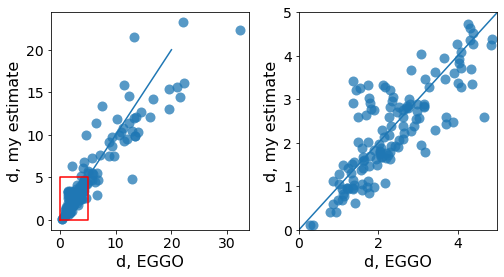

In [68]:
test_data = pd.read_csv('/data/mhoffert/test.csv', index_col=0)

test_data['genome'] = test_data['paths'].apply(lambda x: x.split('/')[-1].split('_grodon')[0])

eggo_data['genome'] = eggo_data['Assembly'].apply(lambda x: 'RS_'+'_'.join(x.split('_')[:2]))

eggo_measurements = eggo_data[eggo_data.genome.isin(test_data.genome.values)].set_index('genome').reindex(test_data['genome'].values)['d']

test_measurements = test_data.set_index('genome')['result_list']

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x=eggo_measurements, 
                y=test_measurements,
                linewidth=0, alpha=0.75, s=100)
plt.plot((0, 20), (0, 20))
plt.tick_params(labelsize=14)
ax.set_ylabel('d, my estimate', fontsize=16)
ax.set_xlabel('d, EGGO', fontsize=16)
plt.plot((0, 0, 5, 5, 0), (0, 5, 5, 0, 0), color='r')
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 5)

ax = fig.add_subplot(1,2,2)
sns.scatterplot(x=eggo_measurements, 
                y=test_measurements,
                linewidth=0, alpha=0.75, s=100)
plt.plot((0, 20), (0, 20))
plt.tick_params(labelsize=14)
ax.set_ylabel('d, my estimate', fontsize=16)
ax.set_xlabel('d, EGGO', fontsize=16)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
fig.subplots_adjust(wspace=0.25)

In [78]:
pd.concat(all_selected_ribosomal_annotations, axis=0)

,orf_uid,name,assignment_acc,precedence,genome
orf_uid,,,,,
NZ_VWOH01000001.1_120,NZ_VWOH01000001.1_120,30S ribosomal protein S20,TIGR00029.2,70,RS_GCF_009268075.1
NZ_VWOH01000001.1_153,NZ_VWOH01000001.1_153,50S ribosomal protein L33,TIGR01023.1,70,RS_GCF_009268075.1
NZ_VWOH01000001.1_169,NZ_VWOH01000001.1_169,50S ribosomal protein L9,TIGR00158.1,70,RS_GCF_009268075.1
NZ_VWOH01000001.1_170,NZ_VWOH01000001.1_170,30S ribosomal protein S18,TIGR00165.1,70,RS_GCF_009268075.1
NZ_VWOH01000001.1_172,NZ_VWOH01000001.1_172,30S ribosomal protein S6,TIGR00166.1,70,RS_GCF_009268075.1
...,...,...,...,...,...
NZ_FZLN01000006.1_29,NZ_FZLN01000006.1_29,50S ribosomal protein L13,TIGR01066.1,70,RS_GCF_900197575.1
NZ_FZLN01000007.1_15,NZ_FZLN01000007.1_15,50S ribosomal protein L34,TIGR01030.1,70,RS_GCF_900197575.1
NZ_FZLN01000007.1_5,NZ_FZLN01000007.1_5,S4 domain-containing protein,pfam01479,5,RS_GCF_900197575.1


In [93]:
piv_acc = pd.concat(all_selected_ribosomal_annotations, axis=0).groupby(['genome', 'name']).first().assign(present=True)['present'].unstack().fillna(False)

In [106]:
accuracy = test_measurements - eggo_measurements

In [102]:
piv_acc.sum()

name
30S ribosomal protein S1                  150
30S ribosomal protein S1 (Provisional)      4
30S ribosomal protein S10                 186
30S ribosomal protein S11                 186
30S ribosomal protein S12                 186
                                         ... 
uL30 family ribosomal protein               7
uL4 family ribosomal protein                7
uS10/mL48 family ribosomal protein          2
uS14 family ribosomal protein               1
uS2 family ribosomal protein               28
Length: 161, dtype: int64

In [113]:
observed_accuracy = pd.Series()
for i in range(len(piv_acc.columns)):
    observed_accuracy.loc[piv_acc.columns[i]] = accuracy.loc[piv_acc.index[piv_acc.iloc[:, i]]].mean()

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [127]:
observed_accuracy = observed_accuracy[observed_accuracy.index.str.contains('ribosomal protein')]

Text(279.075, 0.5, 'Accuracy')

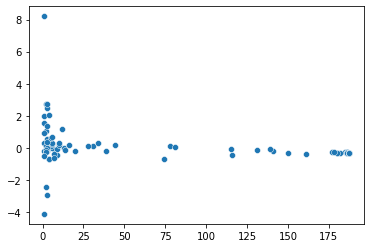

In [128]:
sns.scatterplot(y=observed_accuracy, x=piv_acc.sum())
ax.set_xlabel('Numer of genomes')
ax.set_ylabel('Accuracy')

In [131]:
observed_accuracy[(observed_accuracy.apply(np.abs) > 1.5)].sort_values()

bL33 family ribosomal protein   -4.131091
bL20 family ribosomal protein   -2.946917
ribosomal protein S17           -2.474265
60S ribosomal protein L29        1.536946
ribosomal protein L15e           1.983636
ribosomal protein S7             2.051154
60S ribosomal protein L34        2.485797
uL13 family ribosomal protein    2.714420
60S ribosomal protein L13        2.728125
eS10 family ribosomal protein    8.211253
dtype: float64

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


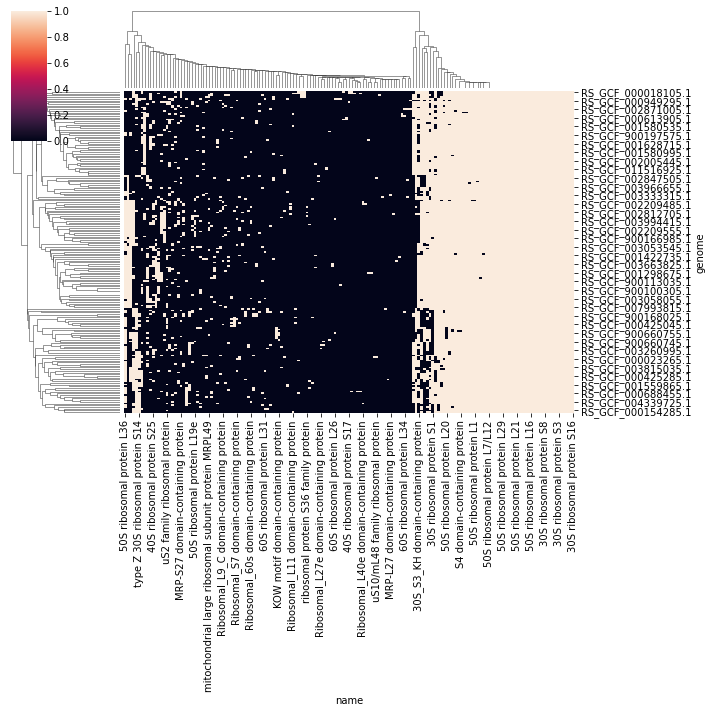

In [99]:
sns.clustermap(piv_acc)

In [60]:
spearmanr(eggo_measurements, test_measurements)

SpearmanrResult(correlation=0.9005942178456209, pvalue=7.42242812624856e-69)

In [62]:
(eggo_measurements - test_measurements).sort_values()

genome
RS_GCF_003330725.1   -8.211253
RS_GCF_900106675.1   -5.944316
RS_GCF_000400995.2   -5.231421
RS_GCF_003858395.1   -4.863123
RS_GCF_001516615.1   -4.363977
                        ...   
RS_GCF_000021485.1    6.047162
RS_GCF_003966655.1    6.613134
RS_GCF_003721225.1    7.132757
RS_GCF_001975725.1    8.198472
RS_GCF_010378095.1    9.996371
Length: 187, dtype: float64

In [65]:
eggo_measurements.loc['RS_GCF_003330725.1']

13.3119004733257

In [66]:
test_measurements.loc['RS_GCF_003330725.1']

21.523153525606

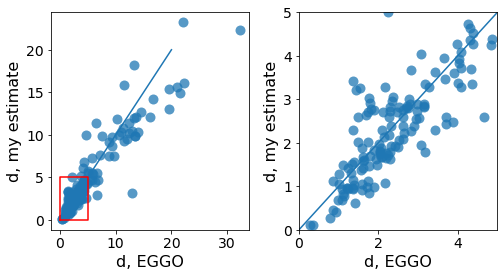

In [132]:
test_data = pd.read_csv('/data/mhoffert/test.csv', index_col=0).rename(columns={'Unnamed: 1':'paths'})

test_data['genome'] = test_data['paths'].apply(lambda x: x.split('/')[-1].split('_grodon')[0])

eggo_data['genome'] = eggo_data['Assembly'].apply(lambda x: 'RS_'+'_'.join(x.split('_')[:2]))

eggo_measurements = eggo_data[eggo_data.genome.isin(test_data.genome.values)].set_index('genome').reindex(test_data['genome'].values)['d']

test_measurements = test_data.set_index('genome')['result_list']

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1,2,1)
sns.scatterplot(x=eggo_measurements, 
                y=test_measurements,
                linewidth=0, alpha=0.75, s=100)
plt.plot((0, 20), (0, 20))
plt.tick_params(labelsize=14)
ax.set_ylabel('d, my estimate', fontsize=16)
ax.set_xlabel('d, EGGO', fontsize=16)
plt.plot((0, 0, 5, 5, 0), (0, 5, 5, 0, 0), color='r')
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 5)

ax = fig.add_subplot(1,2,2)
sns.scatterplot(x=eggo_measurements, 
                y=test_measurements,
                linewidth=0, alpha=0.75, s=100)
plt.plot((0, 20), (0, 20))
plt.tick_params(labelsize=14)
ax.set_ylabel('d, my estimate', fontsize=16)
ax.set_xlabel('d, EGGO', fontsize=16)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
fig.subplots_adjust(wspace=0.25)

In [134]:
spearmanr(eggo_measurements, test_measurements)

SpearmanrResult(correlation=0.9055582674824469, pvalue=8.223642488123595e-71)

In [303]:
test_genome

'RS_GCF_900103005.1'